# ML for Causal Inference: High-Dimensional Controls

In [107]:
library(simstudy)
library(glmnet)
library(stats)
library(rdd)
library(ggplot2)

## Simulate Data

In [108]:
set.seed(1)
# Number of Observations
N <- 1e3

total.covar <- 50 + 1e3
# Number of covariates (excluding W and unobservable)
p <- total.covar - 2

mu.vector <- rep(0, total.covar)
variance.vector <- abs(rnorm(total.covar, mean = 1, sd = .5))
simulated.data <- as.data.frame.matrix(genCorGen(n = N, nvars = total.covar, params1 = mu.vector, params2 = variance.vector, dist = 'normal',  rho = .5,
                            corstr = 'ar1', wide='True'))[2:(total.covar+1)]
colnames(simulated.data)[1] <- 'W' # Running variable for RDD
colnames(simulated.data)[total.covar] <- 'C' # Unobservable variable

# Random assignment for A/B test
T <- rep(0, N)
T[0:(N/2)] <- 1
T <- sample(T)


X <- simulated.data[, 2:(total.covar-1)]

covariate.names <- colnames(X)

error <- rnorm(n = N)



# Make W a function of the X's and unobservable (for RDD)
simulated.data$W <- simulated.data$W + .5 * simulated.data$C + 3 * simulated.data$V80 - 6 * simulated.data$V81
# Assign treatment, based on a threshold along W
treated <- (simulated.data$W > 0) * 1.0

beta.true.linear <- rnorm(p, mean = 5, sd = 5)
beta.true.linear[30:p] <- 0

# Functional Form for Y for A/B test:
Y.ab <- 2.0 * T + data.matrix(X) %*% beta.true.linear + .6 * simulated.data$C + error

# Functional Form for Y for RDD (function of treatment, W, X's, and unobservable C)
Y.rdd <- 1.2 * treated - 4 * simulated.data$W  + data.matrix(X) %*% beta.true.linear + .6 * simulated.data$C + error

df <- cbind(Y.ab, Y.rdd, T, simulated.data)
colnames(df)[1:3] <- c('Y.ab', 'Y.rdd', 'T')

X.colnames <- colnames(X)

# A/B Test

### Use LASSO of Y on X to select H

In [109]:
lasso.fit.outcome <- cv.glmnet(data.matrix(X), df$Y.ab, alpha=1)

coef <- predict(lasso.fit.outcome, type = "nonzero")
H <- X.colnames[unlist(coef)]
# Variables selected by LASSO:
H

[1] "V2"  "V3"  "V4"  "V6"  "V7"  "V8"  "V9"  "V10" "V11" "V12" "V13" "V14"
[13] "V15" "V16" "V17" "V18" "V19" "V20" "V21" "V22" "V23" "V24" "V25" "V26"
[25] "V27" "V28" "V29" "V30"

### Use LASSO of T on X to select K

In [111]:
lasso.fit.propensity <- cv.glmnet(data.matrix(X), df$T, alpha=1)

coef <- predict(lasso.fit.propensity, type = "nonzero")
K <- X.colnames[unlist(coef)]
# Variables selected by LASSO:
K

[1] "V106" "V121" "V150" "V165" "V169" "V170" "V194" "V215" "V398" "V462"
[11] "V743" "V745" "V754" "V843" "V985"

### Perform OLS of Y on T, Controlling for H union K

In [113]:
# Union of selected variables:
H_union_K.names <- unique(c(H, K))
H_union_K.names
sum.H_union_K <- paste(H_union_K.names, collapse = " + ")
eq.H_union_K <- paste("Y.ab ~ T + ", sum.H_union_K)

# OLS regression, using all covariates selected by double selection
fit.double <- lm(eq.H_union_K, data = df)

T.double
ci.double

summary(fit.double)
T.double <- fit.double$coefficients[2]
ci.double <- confint(fit.double, 'T', level = 0.95)

[1] "V2"   "V3"   "V4"   "V6"   "V7"   "V8"   "V9"   "V10"  "V11"  "V12" 
[11] "V13"  "V14"  "V15"  "V16"  "V17"  "V18"  "V19"  "V20"  "V21"  "V22" 
[21] "V23"  "V24"  "V25"  "V26"  "V27"  "V28"  "V29"  "V30"  "V106" "V121"
[31] "V150" "V165" "V169" "V170" "V194" "V215" "V398" "V462" "V743" "V745"
[41] "V754" "V843" "V985"

T 
2.029859

,2.5 %,97.5 %
T,1.859952,2.199765



Call:
lm(formula = eq.H_union_K, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2443 -0.7816 -0.0084  0.8218  4.3678 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -0.021204   0.059345   -0.357    0.721    
T            2.029859   0.086579   23.445   <2e-16 ***
V2           9.658822   0.045359  212.940   <2e-16 ***
V3           6.458172   0.070256   91.923   <2e-16 ***
V4           6.844515   0.036939  185.293   <2e-16 ***
V6           1.814503   0.062949   28.825   <2e-16 ***
V7           6.668349   0.046767  142.588   <2e-16 ***
V8           7.484076   0.046311  161.605   <2e-16 ***
V9           3.073862   0.046149   66.607   <2e-16 ***
V10          3.415421   0.058862   58.024   <2e-16 ***
V11          3.549148   0.039850   89.063   <2e-16 ***
V12         -4.823043   0.047226 -102.128   <2e-16 ***
V13          9.318861   0.064580  144.299   <2e-16 ***
V14          8.491655   0.158814   53.469   <2e-16 ***
V15          8.722814

### Comparison Plots

Warning message in qt(a, object$df.residual):
"NaNs produced"Warning message in data.row.names(row.names, rowsi, i):
"some row.names duplicated: 3,4,5,6 --> row.names NOT used"Warning message:
"Removed 2 rows containing missing values (geom_errorbar)."

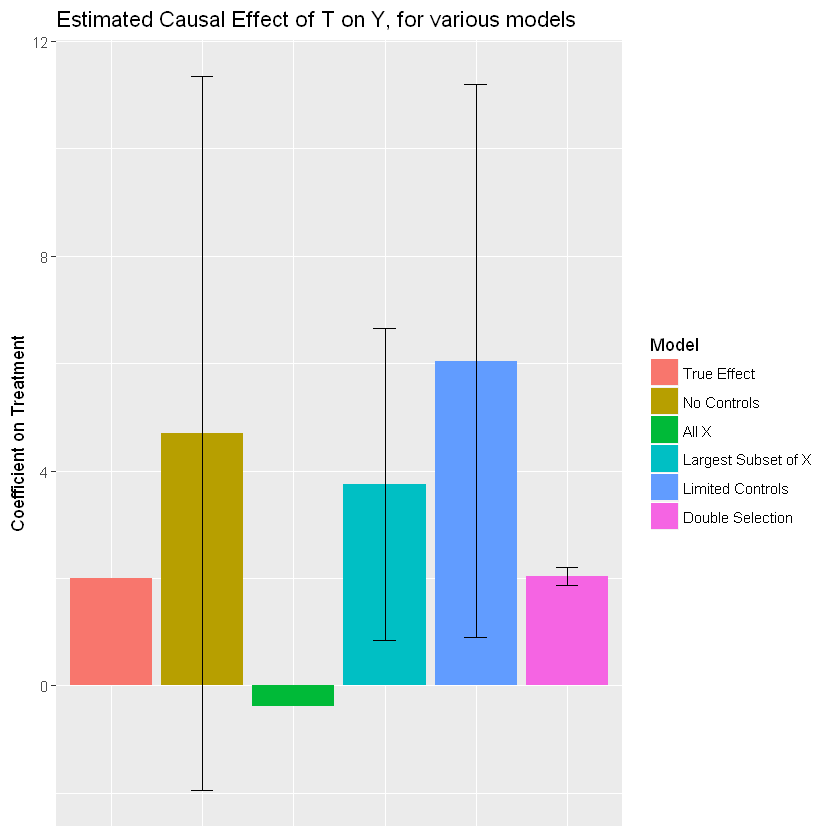

In [114]:
# OLS of Y on T
fit.simple <- lm('Y ~ T', data = df)
#summary(fit.simple)
T.simple <- fit.simple$coefficients[2]
ci.simple <- confint(fit.simple, 'T', level = 0.95)

# OLS of Y on T,controlling for all of X
sum.X <- paste(X.colnames, collapse = " + ")
eq.control.all <- paste("Y.ab ~ T + ", sum.X)

fit.allX <- lm(eq.control.all, data = df)
#summary(fit.allX)
T.allX <- fit.allX$coefficients[2]
ci.allX <- confint(fit.allX, 'T', level = 0.95)

# OLS of Y on T,controlling for (almost) all of X
sum.Xmost <- paste(X.colnames[0:(N-10)], collapse = " + ")
eq.control.almost <- paste("Y.ab ~ T + ", sum.Xmost)

fit.mostX <- lm(eq.control.almost, data = df)
#summary(fit.allX)
T.mostX <- fit.mostX$coefficients[2]
ci.mostX <- confint(fit.mostX, 'T', level = 0.95)

# OLS of Y on T, with a subset of X
sum.X.subset <- paste(c(X.colnames[5:15], X.colnames[80:90]), collapse = " + ")
eq.control.subset <- paste("Y.ab ~ T + ", sum.X.subset)

fit.subsetX <- lm(eq.control.subset, data = df)
#summary(fit.subsetX)
T.subsetX <- fit.subsetX$coefficients[2]
ci.subsetX <- confint(fit.subsetX, 'T', level = 0.95)

# Vector of T results
coefs.ab <- c(2.0, T.simple, T.allX, T.mostX, T.subsetX, T.double)

ci.low <- c(NaN, ci.simple[1], ci.allX[1], ci.mostX[1], ci.subsetX[1], ci.double[1])
ci.high <- c(NaN, ci.simple[2], ci.allX[2], ci.mostX[2], ci.subsetX[2], ci.double[2])

dat <- cbind(coefs.ab, ci.low, ci.high, c('True Effect', 'No Controls', 'All X', 'Largest Subset of X', 'Limited Controls', 'Double Selection'))
colnames(dat)[4] <- 'Model'
dat <- data.frame(dat)

dat$coefs.ab <- as.double(levels(dat$coefs.ab))[dat$coefs.ab]
dat$ci.low <- as.double(levels(dat$ci.low))[dat$ci.low]
dat$ci.high <- as.double(levels(dat$ci.high))[dat$ci.high]
dat$Model <- factor(dat$Model, levels = dat$Model)

dodge <- position_dodge(width = 0.9)
limits <- aes(ymax = dat$ci.high,
              ymin = dat$ci.low)

p <- ggplot(data = dat, aes(x = Model, y = coefs.ab, fill = Model))

p + geom_bar(stat = "identity", position = dodge) +
  geom_errorbar(limits, position = dodge, width = 0.25) +
    ylab("Coefficient on Treatment") +
    ggtitle("Estimated Causal Effect of T on Y, for various models") +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

# RDD

### Use LASSO of Y on X to select H

In [115]:
lasso.fit.outcome <- cv.glmnet(data.matrix(X), df$Y.rdd, alpha=1)

coef <- predict(lasso.fit.outcome, type = "nonzero")
H <- X.colnames[unlist(coef)]
# Variables selected by LASSO:
H

[1] "V2"    "V3"    "V4"    "V6"    "V7"    "V8"    "V9"    "V10"   "V11"  
[10] "V12"   "V13"   "V14"   "V15"   "V16"   "V17"   "V18"   "V19"   "V20"  
[19] "V21"   "V22"   "V23"   "V24"   "V25"   "V26"   "V27"   "V28"   "V29"  
[28] "V30"   "V48"   "V80"   "V81"   "V126"  "V133"  "V186"  "V243"  "V307" 
[37] "V381"  "V419"  "V679"  "V680"  "V745"  "V787"  "V832"  "V835"  "V880" 
[46] "V987"  "V999"  "V1043" "V1049"

### Use LASSO of W on X to select K

In [116]:
lasso.fit.propensity <- cv.glmnet(data.matrix(X), df$W, alpha=1)

coef <- predict(lasso.fit.propensity, type = "nonzero")
K <- X.colnames[unlist(coef)]
# Variables selected by LASSO:
K

[1] "V2"    "V80"   "V81"   "V1049"

### Perform RDD of Y on W, Controlling for H union K

In [117]:
# Union of selected variables:
H_union_K.names <- unique(c(H, K))
H_union_K.names
sum.H_union_K <- paste(H_union_K.names, collapse = " + ")
eq.H_union_K <- paste("Y.rdd ~ W | ", sum.H_union_K)

# RDD, using all covariates selected by double selection
fit.rdd <- RDestimate(eq.H_union_K, data = df)
summary(fit.rdd)

[1] "V2"    "V3"    "V4"    "V6"    "V7"    "V8"    "V9"    "V10"   "V11"  
[10] "V12"   "V13"   "V14"   "V15"   "V16"   "V17"   "V18"   "V19"   "V20"  
[19] "V21"   "V22"   "V23"   "V24"   "V25"   "V26"   "V27"   "V28"   "V29"  
[28] "V30"   "V48"   "V80"   "V81"   "V126"  "V133"  "V186"  "V243"  "V307" 
[37] "V381"  "V419"  "V679"  "V680"  "V745"  "V787"  "V832"  "V835"  "V880" 
[46] "V987"  "V999"  "V1043" "V1049"


Call:
RDestimate(formula = eq.H_union_K, data = df)

Type:
sharp 

Estimates:
           Bandwidth  Observations  Estimate  Std. Error  z value  Pr(>|z|) 
LATE       2.514      403           1.209     0.2502      4.831    1.358e-06
Half-BW    1.257      218           1.353     0.3349      4.040    5.353e-05
Double-BW  5.028      727           1.226     0.1821      6.730    1.694e-11
              
LATE       ***
Half-BW    ***
Double-BW  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

F-statistics:
           F      Num. DoF  Denom. DoF  p
LATE       13880  52        350         0
Half-BW     7309  52        165         0
Double-BW  26782  52        674         0
